In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa, librosa.display

## Analysing the Base Data 

In [2]:
file = "sample_metal.wav"
signal, sample_rate = librosa.load(file, sr=22050)

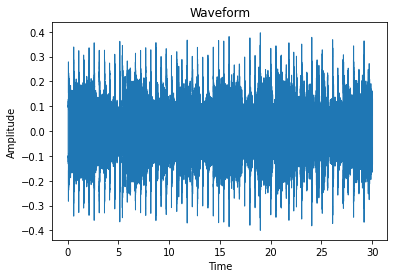

In [3]:
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

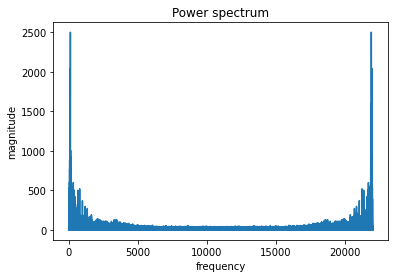

In [4]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0,sample_rate,len(magnitude))
plt.plot(frequency,magnitude)
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.title("Power spectrum")
plt.show()

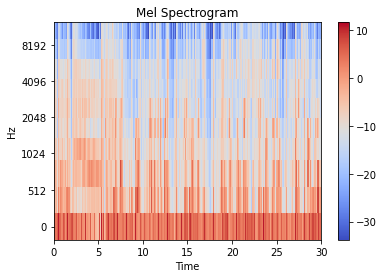

In [5]:
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=10, fmax=8000)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
librosa.display.specshow(data=log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sample_rate)
plt.title("Mel Spectrogram")
plt.colorbar()
plt.show()

### Load Dataset

In [6]:
DATA_PATH = "preprocessed_mfcc_data.json"

with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

X = np.array(data["mfcc"])
y = np.array(data["labels"])

### Split Train Test sets

In [7]:
test_size = 0.25
validation_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=validation_size
)
input_shape = (X_train.shape[1], X_train.shape[2])

## Model Architecture
- We're using 2 LSTMs which process the input, for feature extraction and understanding the latent space.
- A Fully-Connected Dense Layer is added, with ReLu activation function to learn the data.
- The Output is finally passed through a SoftMax to obtain the result genre class.
- The Adam optimiser is used, coupled with sparse_categorical_crossentropy as loss function

In [8]:
model = keras.Sequential()

# 2 LSTM layers
model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(keras.layers.LSTM(64))

# dense layer
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(10, activation="softmax"))

# Optimiser
optimiser = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 259, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


## Training and analysis

In [9]:
history = model.fit(
        X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30
    )

Epoch 1/30
94/94 [==============================] - 40s 371ms/step - loss: 2.2706 - accuracy: 0.1446 - val_loss: 2.2281 - val_accuracy: 0.1883
Epoch 2/30
94/94 [==============================] - 44s 473ms/step - loss: 2.1758 - accuracy: 0.2287 - val_loss: 2.1296 - val_accuracy: 0.2710
Epoch 3/30
94/94 [==============================] - 38s 402ms/step - loss: 2.0505 - accuracy: 0.3005 - val_loss: 1.9961 - val_accuracy: 0.3324
Epoch 4/30
94/94 [==============================] - 40s 429ms/step - loss: 1.9164 - accuracy: 0.3406 - val_loss: 1.8698 - val_accuracy: 0.3685
Epoch 5/30
94/94 [==============================] - 58s 619ms/step - loss: 1.8032 - accuracy: 0.3763 - val_loss: 1.7688 - val_accuracy: 0.3952
Epoch 6/30
94/94 [==============================] - 42s 447ms/step - loss: 1.7143 - accuracy: 0.4100 - val_loss: 1.6966 - val_accuracy: 0.3992
Epoch 7/30
94/94 [==============================] - 48s 507ms/step - loss: 1.6320 - accuracy: 0.4451 - val_loss: 1.6534 - val_accuracy: 0.4032

In [10]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

40/40 - 3s - loss: 1.2623 - accuracy: 0.5548 - 3s/epoch - 64ms/step

Test accuracy: 0.5548439025878906
